# Import Data and Preprocessing

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"applejin","key":"0b93924b947f72a219bb11234c07cc77"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [01:34<00:00, 43.2MB/s]
100% 3.75G/3.75G [01:34<00:00, 42.7MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_vs_fake/real-vs-fake/vali

In [ ]:
import os
import glob
import pandas as pd

main_path = './real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

images_df = {
    "folder": [],
    "image_path": [],
    "label": []
}

for folder in os.listdir(main_path):
    for label in os.listdir(os.path.join(main_path, folder)):
        for img in glob.glob(os.path.join(main_path, folder, label, "*.jpg")):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)
images_df = pd.DataFrame(images_df)

In [ ]:
from PIL import Image, ImageChops, ImageEnhance


# ELA function to convert images
def convert_to_ela_image_array(image_array, quality=90):
    # Convert numpy array to PIL Image
    image = Image.fromarray((image_array * 255).astype('uint8'))
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    resaved_image = Image.open(buffer)

    ela_image = ImageChops.difference(image, resaved_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff else 1

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return np.array(ela_image) / 255.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def ela_preprocessor(image):
    return convert_to_ela_image_array(image)

image_train_gen = ImageDataGenerator(
    preprocessing_function=ela_preprocessor,
    horizontal_flip=True
)

image_gen = ImageDataGenerator(
    preprocessing_function=ela_preprocessor
)

In [ ]:
train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
import shutil
import numpy as np

def create_subset(original_dir, subset_dir, fraction=0.5):
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

    # For each category in the original directory
    for category in os.listdir(original_dir):
        category_dir = os.path.join(original_dir, category)
        subset_category_dir = os.path.join(subset_dir, category)
        if not os.path.exists(subset_category_dir):
            os.makedirs(subset_category_dir)

        images = os.listdir(category_dir)
        np.random.shuffle(images)
        subset_size = int(len(images) * fraction)

        # Copy a subset of images
        for image in images[:subset_size]:
            source_path = os.path.join(category_dir, image)
            destination_path = os.path.join(subset_category_dir, image)
            shutil.copy(source_path, destination_path)

# Paths for the subsets
train_subset_dir = os.path.join(main_path, 'train_subset')
valid_subset_dir = os.path.join(main_path, 'valid_subset')
test_subset_dir = os.path.join(main_path, 'test_subset')

# Create subsets
create_subset(train_dir, train_subset_dir)
create_subset(valid_dir, valid_subset_dir)
create_subset(test_dir, test_subset_dir)


In [ ]:
train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

train_ds = image_train_gen.flow_from_directory(
    train_subset_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_subset_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_subset_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 50000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf

# MobileNet Model setup
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

for layer in base_model.layers[-20:]: # unfreeze the last 20 layers
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

17225924/17225924 [==============================] - 1s 0us/step


# Load the saved best weights

In [ ]:
files.upload()

Saving model_best_weights.h5 to model_best_weights.h5


In [ ]:
model.load_weights('model_best_weights.h5')

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='model_best_weights_2.h5', monitor='val_loss', save_best_only=True)
]

In [ ]:
# Training
import io
import numpy as np
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.8698

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 492s 606ms/step - loss: 0.3051 - accuracy: 0.8698 - val_loss: 0.4834 - val_accuracy: 0.7728
Epoch 2/10
782/782 [==============================] - 459s 587ms/step - loss: 0.2651 - accuracy: 0.8891 - val_loss: 1.1809 - val_accuracy: 0.5992
Epoch 3/10
782/782 [==============================] - 463s 593ms/step - loss: 0.2300 - accuracy: 0.9048 - val_loss: 0.4613 - val_accuracy: 0.8110
Epoch 4/10
782/782 [==============================] - 454s 581ms/step - loss: 0.2052 - accuracy: 0.9160 - val_loss: 0.9280 - val_accuracy: 0.7035
Epoch 5/10
782/782 [==============================] - 479s 612ms/step - loss: 0.1782 - accuracy: 0.9284 - val_loss: 0.7839 - val_accuracy: 0.7683
Epoch 6/10
782/782 [==============================] - 463s 593ms/step - loss: 0.1551 - accuracy: 0.9391 - val_loss: 0.5110 - val_accuracy: 0.8180
Epoch 7/10
782/782 [==============================] - 456s 583ms/step - loss: 0.1384 - accuracy: 0.9455 - val_loss: 0.8409 - val_accura

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

157/157 [==============================] - 80s 505ms/step - loss: 0.5419 - accuracy: 0.8349
Test accuracy: 0.8349000215530396, Test loss: 0.5418945550918579


# Test on Stable Diffusion images

  Fake images used here are collected [here](https://www.kaggle.com/datasets/bwandowando/faces-dataset-using-stable-diffusion-v14).
  
  We manually combined it with some real images that you can find it [here](https://www.kaggle.com/datasets/atulanandjha/lfwpeople/data)

In [ ]:
files.upload()

Saving Stable Diffusion_Face.zip to Stable Diffusion_Face.zip


In [ ]:
!unzip "Stable Diffusion_Face"

Archive:  Stable Diffusion_Face.zip
   creating: Stable Diffusion_Face/
  inflating: Stable Diffusion_Face/.DS_Store  
  inflating: __MACOSX/Stable Diffusion_Face/._.DS_Store  
   creating: Stable Diffusion_Face/real/
   creating: Stable Diffusion_Face/fake/
  inflating: Stable Diffusion_Face/real/George_W_Bush_0434.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._George_W_Bush_0434.jpg  
  inflating: Stable Diffusion_Face/real/Vladimir_Putin_0012.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Vladimir_Putin_0012.jpg  
  inflating: Stable Diffusion_Face/real/Gloria_Macapagal_Arroyo_0017.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Gloria_Macapagal_Arroyo_0017.jpg  
  inflating: Stable Diffusion_Face/real/Silvio_Berlusconi_0005.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Silvio_Berlusconi_0005.jpg  
  inflating: Stable Diffusion_Face/real/Nancy_Pelosi_0001.jpg  
  inflating: __MACOSX/Stable Diffusion_Face/real/._Nancy_Pelosi_0001.jpg  
  inflat

In [ ]:
sd_dir = './Stable Diffusion_Face'

images_df = {
    "image_path": [],
    "label": []
}

# Adjust the img_format based on file type specifics, assuming 'fake' uses png and 'real' uses jpg
for label in os.listdir(sd_dir):  # iterate on fake and real folders (labels)
    if label == "fake":
        img_format = "*.png"
    elif label == "real":
        img_format = "*.jpg"
    else:
        continue  # Skip any folder that is not 'fake' or 'real'

    for img in glob.glob(os.path.join(sd_dir, label, img_format)):
        images_df["image_path"].append(img)
        images_df["label"].append(label)

images_df = pd.DataFrame(images_df)
print(images_df)

# Function to convert image array to ELA image array
def convert_to_ela_image_array(image_array, quality=90):
    # Convert the input array to a PIL Image
    image = Image.fromarray((image_array * 255).astype('uint8'))
    # Save the image to a buffer instead of a file
    buffer = io.BytesIO()
    image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    # Load the image from the buffer
    resaved_image = Image.open(buffer)

    # Calculate the difference
    ela_image = ImageChops.difference(image, resaved_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff else 1

    # Scale the ELA image
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.convert('RGB')
    return np.array(ela_image) / 255.0

# Define a wrapper function that TensorFlow can use
def ela_preprocessor(image):
    return convert_to_ela_image_array(image)

# Set up the ImageDataGenerator with the ELA preprocessing
image_gen = ImageDataGenerator(
    preprocessing_function=ela_preprocessor  # Apply ELA preprocessing
)

# Assuming you have the dataframe 'images_df' set up correctly as shown before
test_ds = image_gen.flow_from_dataframe(
    dataframe=images_df,
    directory=None,  # No directory since paths are in the dataframe
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    class_mode='binary',
    batch_size=32,
    shuffle=False  # Shuffle is disabled for consistent test output
)

# Load the model and evaluate on the new test dataset
model.load_weights(filepath='model_best_weights.h5')
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


                                            image_path label
0    ./Stable Diffusion_Face/fake/seed_970441_00127...  fake
1    ./Stable Diffusion_Face/fake/seed_970458_00144...  fake
2    ./Stable Diffusion_Face/fake/seed_970418_00104...  fake
3    ./Stable Diffusion_Face/fake/seed_970415_00101...  fake
4    ./Stable Diffusion_Face/fake/seed_970324_00009...  fake
..                                                 ...   ...
295  ./Stable Diffusion_Face/real/Donald_Rumsfeld_0...  real
296  ./Stable Diffusion_Face/real/Jean_Charest_0015...  real
297  ./Stable Diffusion_Face/real/George_W_Bush_043...  real
298  ./Stable Diffusion_Face/real/Juan_Carlos_Ferre...  real
299  ./Stable Diffusion_Face/real/John_Ashcroft_002...  real

[300 rows x 2 columns]
Found 300 validated image filenames belonging to 2 classes.
10/10 [==============================] - 5s 411ms/step - loss: 4.6351 - accuracy: 0.0467
Test Loss: 4.635136127471924, Test Accuracy: 0.046666666865348816


# Code to draw the ELA preprocessed images

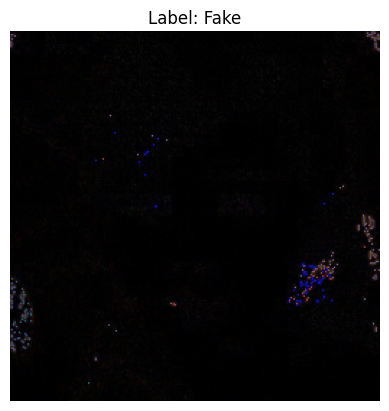

In [ ]:
## 这个code用来画ela图像

import matplotlib.pyplot as plt

# Fetch a batch of images and labels
images, labels = next(train_ds)  # This gets the next batch from the dataset

# Select the first image and label from the batch
image = images[20]  # First image in the batch
label = labels[20]  # First label in the batch

# Convert the image from normalized format back to integer pixel values
image_display = (image * 255).astype('uint8')

# Display the image
plt.imshow(image_display)
plt.title(f'Label: {"Real" if label == 1 else "Fake"}')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


# Test the model using Stable Diffusion images (+gradCAM)


This is the data we used to do dataset augmentation later on. You can find the dataset [here](https://github.com/tobecwb/stable-diffusion-face-dataset.git).

In [ ]:
files.upload()

Saving model_best_weights(基础+ela第一次).h5 to model_best_weights(基础+ela第一次).h5


In [ ]:
model.load_weights(filepath='model_best_weights.h5')

In [ ]:
!git clone https://github.com/tobecwb/stable-diffusion-face-dataset.git

Cloning into 'stable-diffusion-face-dataset'...
remote: Enumerating objects: 9040, done.
remote: Counting objects: 100% (3024/3024), done.
remote: Compressing objects: 100% (3017/3017), done.
remote: Total 9040 (delta 7), reused 3021 (delta 4), pack-reused 6016
Receiving objects: 100% (9040/9040), 3.02 GiB | 17.71 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (9005/9005), done.


In [ ]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import cm
from PIL import Image, ImageChops, ImageEnhance
import io
import cv2
from IPython.display import display, Image as DisplayImage

# ELA Helper Function
def convert_to_ela_image_array(image_path, quality=90):
    original_image = Image.open(image_path)
    buffer = io.BytesIO()
    original_image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    resaved_image = Image.open(buffer)

    ela_image = ImageChops.difference(original_image, resaved_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff else 1

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    ela_image = ela_image.convert('RGB')
    ela_image = ela_image.resize((256, 256))  # Ensure the image has the same size as model input
    ela_image = np.array(ela_image)
    ela_image = ela_image / 255.0  # Normalize the image array
    return np.expand_dims(ela_image, axis=0)  # Add batch dimension

def get_fused_heatmap(img_path, model):
    img_array = convert_to_ela_image_array(img_path)
    layer_names = [layer.name for layer in model.layers if all(x not in layer.name for x in ["input", "bn", "relu", "dense", "pad", "pool", "conv1"])]

    heatmaps = []
    for layer_name in layer_names:
        heatmap = make_gradcam_heatmap(img_array, model, layer_name)
        # Resize the heatmap to match the original image size
        heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
        heatmaps.append(heatmap_resized)

    # Averaging heatmaps from multiple layers
    fused_heatmap = np.mean(heatmaps, axis=0)
    return fused_heatmap

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(DisplayImage(cam_path))

<ipython-input-18-7e152467b77d>:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


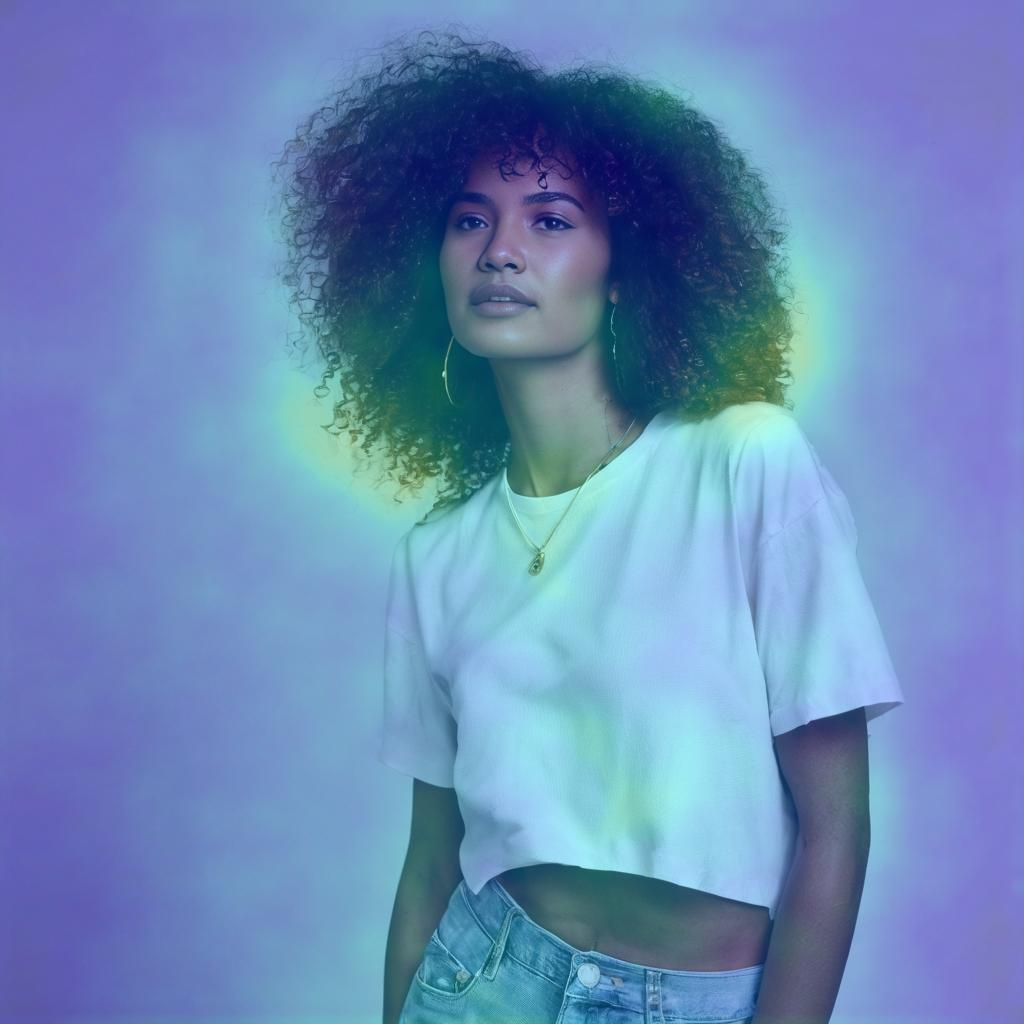

In [ ]:
img_path = "/content/stable-diffusion-face-dataset/1024/woman/woman_0001.jpg"
fused_heatmap = get_fused_heatmap(img_path, model)
save_and_display_gradcam(img_path, fused_heatmap)

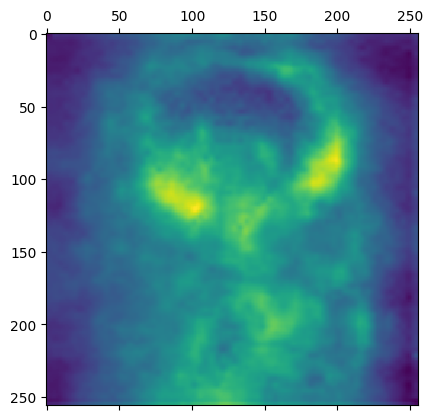

In [ ]:
plt.matshow(fused_heatmap)

## See the gradCAM graph of the same image using the model after dataset Augmentation

In [ ]:
files.upload()

Saving model_best_weights（sd+gan+eLA）.h5 to model_best_weights（sd+gan+eLA）.h5


In [ ]:
model.load_weights('model_best_weights2.h5')

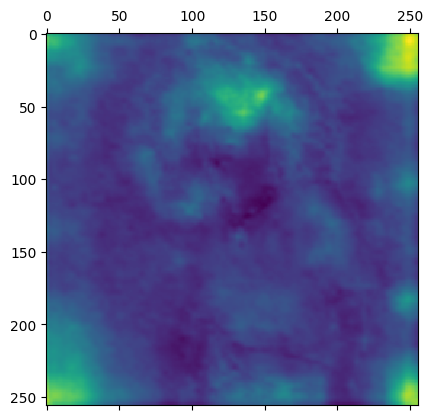

In [ ]:
img_path = "/content/stable-diffusion-face-dataset/1024/woman/woman_0001.jpg"
fused_heatmap1 = get_fused_heatmap(img_path, model)
plt.matshow(fused_heatmap1)

<ipython-input-31-7e152467b77d>:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


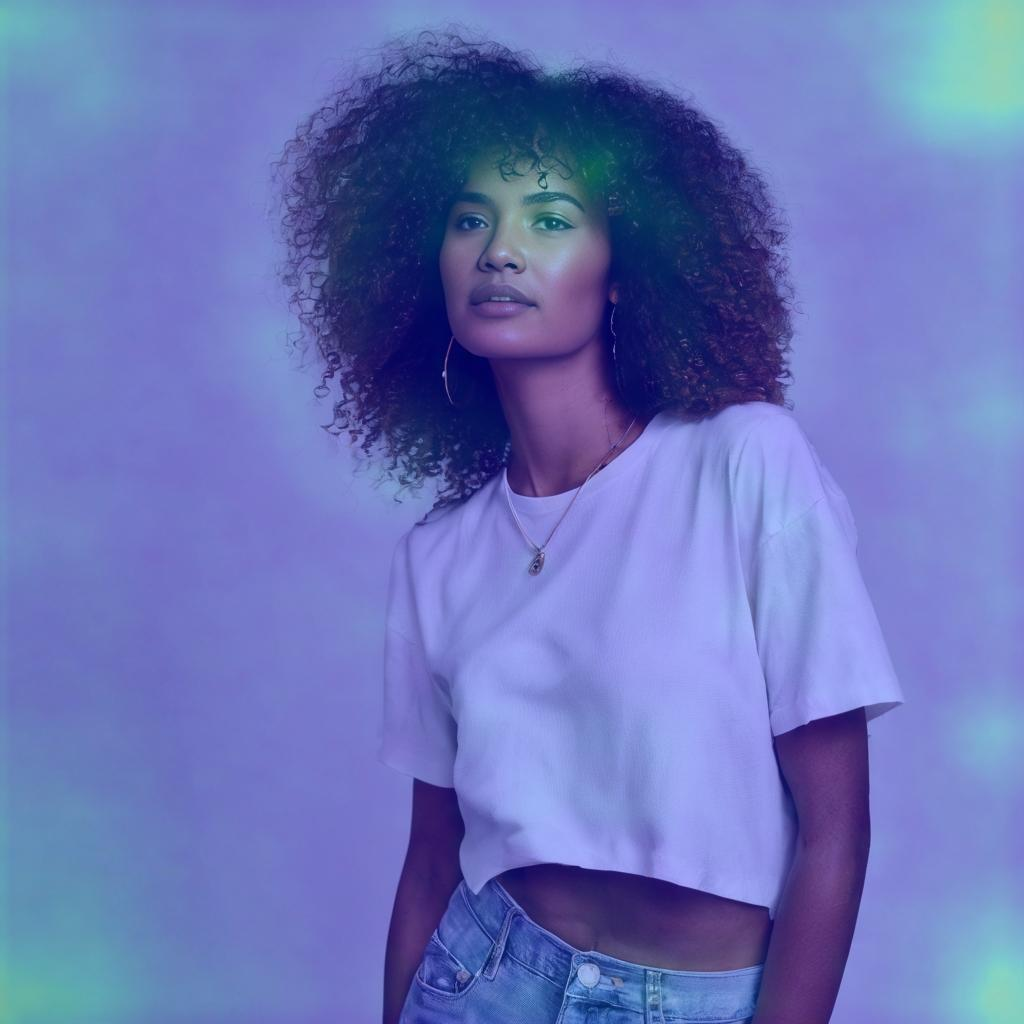

In [ ]:
img_path = "/content/stable-diffusion-face-dataset/1024/woman/woman_0001.jpg"
fused_heatmap = get_fused_heatmap(img_path, model)
save_and_display_gradcam(img_path, fused_heatmap)

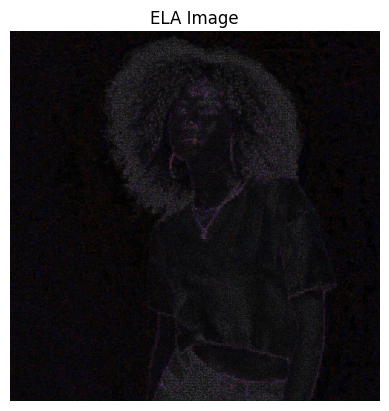

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
import numpy as np

def ela_image(img_path, quality):
    """Generate an ELA image on the given image file path with the specified JPEG quality."""
    # Open the image
    original = Image.open(img_path)

    # Save the image to a temporary JPEG file to simulate compression, then reload it
    temporary_path = "temp_ela.jpg"
    original.save(temporary_path, 'JPEG', quality=quality)
    compressed = Image.open(temporary_path)

    # Calculate the difference between the original and compressed images
    ela = ImageChops.difference(original, compressed)

    # Scale the colors to make differences more visible
    extrema = ela.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff > 0 else 1
    ela = ImageEnhance.Brightness(ela).enhance(scale)

    return ela

# Path to the image
img_path = "/content/stable-diffusion-face-dataset/1024/woman/woman_0001.jpg"

# Generate the ELA image
ela_img = ela_image(img_path, quality=90)

# Display the ELA image
plt.imshow(ela_img)
plt.title('ELA Image')
plt.axis('off')
plt.show()
